In [1]:
# Imports
import astropy.io.fits as fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import astro_imaging.config as acfg
import astro_imaging.images as aimg
import astro_imaging.hsc as hsc

In [2]:
# Plot settings
figsize = (20, 20)
mpl.rcParams['figure.figsize'] = figsize
mpl.rcParams['image.origin'] = 'lower'

In [3]:
# Define all paths as this notebook's local file path
paths = acfg.Paths(images=os.path.dirname(os.path.realpath("__file__")))
func_path = aimg.func_path_default

In [4]:
# Download a cutout for a source
ra, dec = '222.51551376', '0.09749601'
source_prefix = f'{ra},{dec}'
ra, dec = (float(x) for x in (ra, dec))
bands = 'irg'
size_cutout_pix = 300
size_cutout_asec = (hsc.scale_pixel*size_cutout_pix*u.arcsec)
source = f'{source_prefix}_{size_cutout_pix}x{size_cutout_pix}'

imgs = {}
for band in bands:
    filename = func_path(source, band, paths=paths)
    if not os.path.isfile(filename):
        cmd = hsc.download_cutout(
            ra, dec, filename,
            band=band,
            half_width=f'{0.5*size_cutout_asec.value}{size_cutout_asec.unit}',
            get_mask=False,
            get_variance=False,
        )
        print(f'Downloading from {cmd}')
    img_fits = fits.open(filename)
    imgs[band] = img_fits

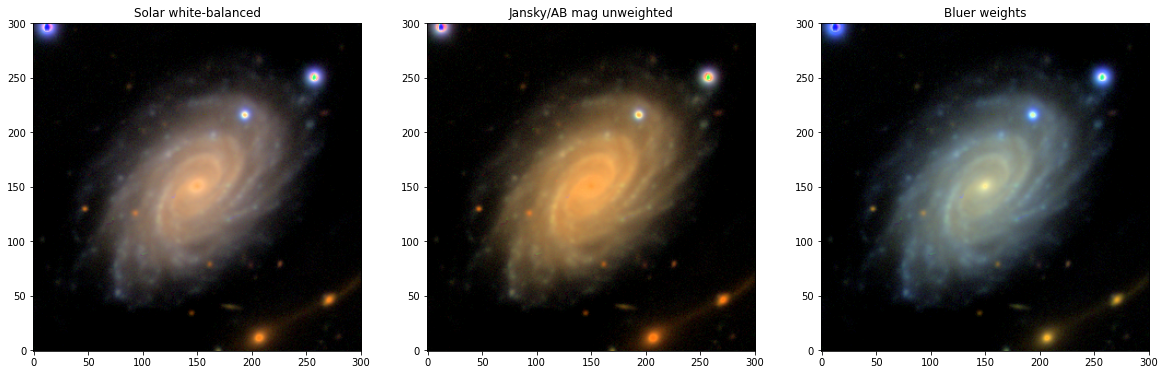

In [5]:
# Plot images
bands_weights = hsc.get_bands_weights_default()
bands_weights = {band: bands_weights[band] for band in bands}

img_rgb = aimg.make_img_rgb(
    source, bands_weights, images=imgs, kwargs_make_rgb=dict(stretch=2, Q=6),
    # return_imgs=True, return_imgs_fits=True,
)

kwargs = {
    'images': imgs,
    'kwargs_make_rgb': {'stretch':2, 'Q': 6},
}
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img_rgb)
ax[0].set_title('Solar white-balanced')
ax[1].imshow(aimg.make_img_rgb(source, bands_weights={b: 1. for b in bands}, **kwargs))
ax[1].set_title('Jansky/AB mag unweighted')
ax[2].imshow(aimg.make_img_rgb(
    source, bands_weights={b: v for b, v in zip(bands, [2/3, 1, 5/3])},
    **kwargs,
))
ax[2].set_title('Bluer weights')
plt.show()

In the images above, the left image is generated with a weighting such that solar colours appear white. Refer to the HSC module for how the weights were determined for HSC filters/bands, which are similar to the SDSS system. This is meant to roughly approximate what a galaxy would look like to the human eye - to the extent that this is possible with the HSC filter set, since the gri bands go well into the infrared, beyond human red sensitivity. Nonetheless, it illustrates how the 'default' unweighted scheme with fluxes in Janskys (in other words, AB mags) makes even disky low-redshift galaxies look almost uniformly yellow-orange.

Having said that, any given linear weighting is valid (or at least not wrong) as long as one correctly preserves therelative intensities of pixels with the same colour (i.e. by using the Lupton method). The image at the right gives more weight to the blue and green channels, yielding cooler colours. It is not wrong, and indeed one might prefer to makea source with solar colours not look white to emphasize certain features. For example, one could use weights that make solar colours at a given redshift look white to represent a galaxy's rest-frame colours, which would make foreground sources look bluer. Nonetheless, I believe that solar white balance should be the natural choice in the absence of a compelling alternative.

In [6]:
# Get PSFs
psfs = {}
shapes_psf = {}
for band in bands:
    filename = func_path(source_prefix, band, paths=paths, postfix='_psf.fits')
    if not os.path.isfile(filename):
        cmd = hsc.download_psf(ra, dec, filename, band=band)
        print(f'Downloading PSF from {cmd}')
    psf = fits.open(filename)
    psfs[band] = psf
    shapes_psf[band] = psf[0].data.shape

In [7]:
# Zero-pad PSFs to same size
size_max = np.max(np.array(list(shapes_psf.values())), axis=0)
imgs_psf = {}
for band, psf in psfs.items():
    shape_psf = shapes_psf[band]
    diff = (size_max - shape_psf)//2
    img_psf = np.zeros(size_max)
    img_psf[diff[0]:shape_psf[0] + diff[0], diff[1]:shape_psf[1] + diff[1]] = psf[0].data
    imgs_psf[band] = img_psf

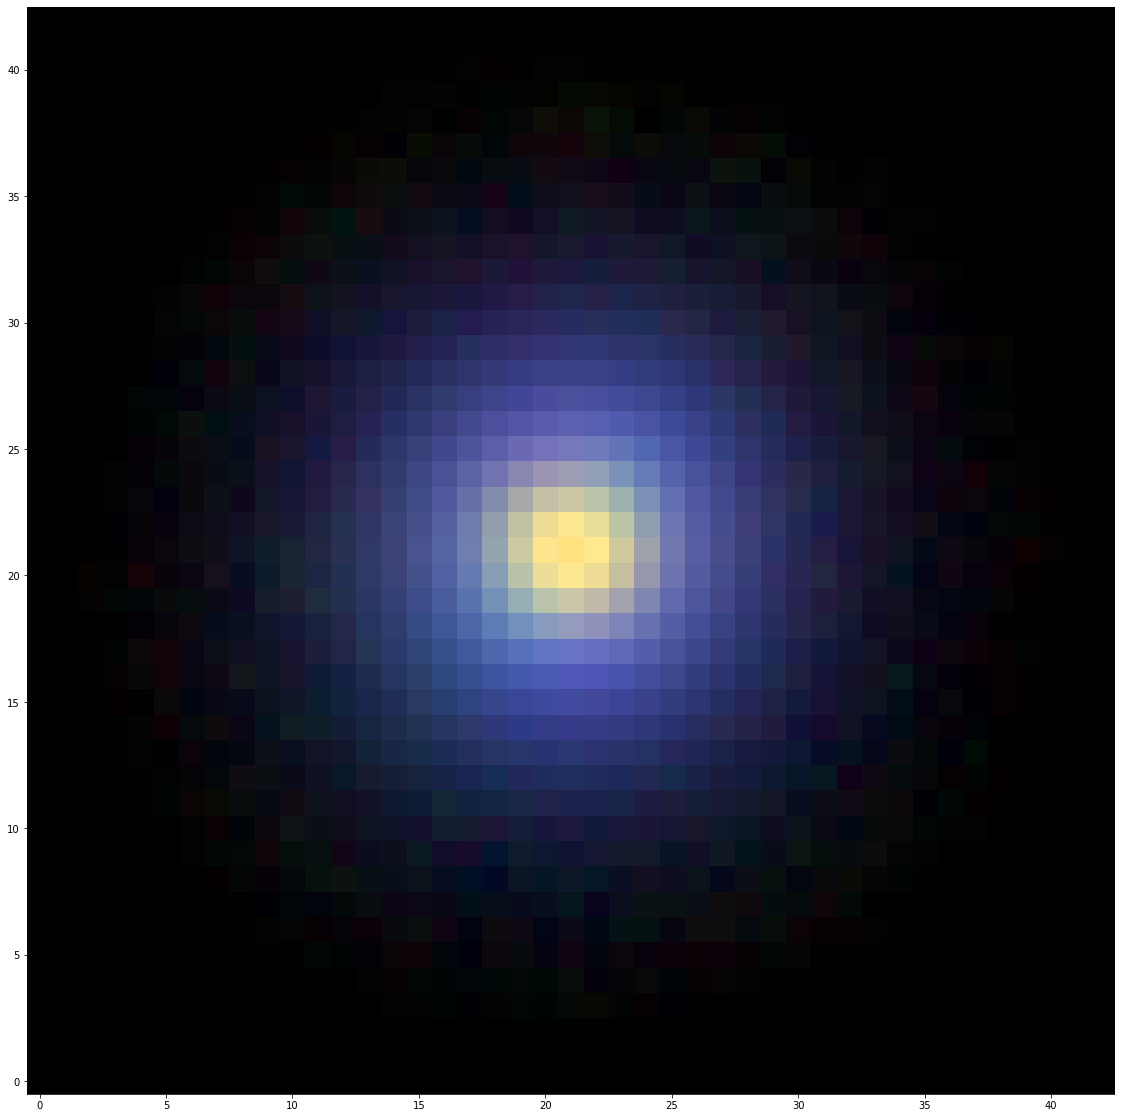

In [8]:
# Plot PSF
plt.imshow(aimg.make_img_rgb(None, images=imgs_psf, bands_weights={b: 1. for b in bands},
                             kwargs_make_rgb= {'stretch':6e-4, 'Q': 10}, hdu_image=None))